# Super-Resolution z wykorzystaniem modelu ESPCN oraz RDN - porównanie

ESPCN - Image Super-Resolution using an Efficient Sub-Pixel CNN, opracowane na podstawie artykułu https://arxiv.org/pdf/1609.05158

RDN - Residual Dense Network for Image Super-Resolution, opracowane na podstawie artykułu https://arxiv.org/abs/1802.08797


## 1. Zestaw danych

Został wykorzystany zestaw danych DIV2K, dostępny pod adresem: http://data.vision.ee.ethz.ch/cvl/DIV2K.

In [ ]:
import os
import matplotlib.pyplot as plt
from zestawy_danych import DIV2K #służy do pobierania zdjęć, zdjęcia zostaną umieszczone w folderze dane

%matplotlib inline

In [ ]:
train_data = DIV2K(scale=4, subset='train', downgrade='bicubic') #dane treningowe
valid_data = DIV2K(scale=4, subset='valid', downgrade='bicubic') #dane validacyjne

In [ ]:
train_ds = train_data.dataset(batch_size=16, random_transform=True)
valid_ds = valid_data.dataset(batch_size=1)

246915072/246914039 [==============================] - 9s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_LR_bicubic_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_LR_bicubic_X4.cache.
3530604544/3530603713 [==============================] - 120s 0us/step
Caching decoded images in .div2k/caches/DIV2K_train_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_train_HR.cache.
31506432/31505881 [==============================] - 2s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_LR_bicubic_X4.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_LR_bicubic_X4.cache.
448995328/448993893 [==============================] - 16s 0us/step
Caching decoded images in .div2k/caches/DIV2K_valid_HR.cache ...
Cached decoded images in .div2k/caches/DIV2K_valid_HR.cache.


## 2. Trening

Trening dla każdego modelu ma 2000 kroków i jest oceniany co 1000 kroków na pierwszych 10 obrazach zestawu walidacyjnego DIV2K. 
Gdy PSNR ulega poprawie, checkpoint jest zapisywany.

In [ ]:
from ESPCN import espcn #model espcn
from RDN import rdn #model rdn
from training import ESPCNTrainer, RDNTrainer #treningi obu modeli

### 2.1 ESPCN 
Wagi z trenowanego modelu zapisane zostaną do pliku weights/espcn/weights.h5. 

In [ ]:
#stworzenie pliku weights.h5 w katalogu weights/espcn
wagi_katalog = f'weights/espcn'
wagi_plik = os.path.join(wagi_katalog, 'weights.h5')

os.makedirs(wagi_katalog, exist_ok=True)

In [ ]:
trainer_ESPCN = ESPCNTrainer(model=espcn(scale=4, num_res_blocks=32), 
                      checkpoint_dir=f'.ckpt/espcn')

In [ ]:
trainer_ESPCN.train(train_ds,
              valid_ds.take(10),
              steps=2000, 
              evaluate_every=1000, 
              save_best_only=True)

1000/2000: loss = 16.262, PSNR = 23.858484 (3979.32s)
2000/2000: loss = 9.913, PSNR = 27.497492 (3915.24s)


In [ ]:
#zapisanie wag do pliku
trainer_ESPCN.model.save_weights(wagi_plik)

### 2.2 RDN
Wagi z trenowanego modelu zapisane zostaną do pliku weights/rdn/weights.h5. 

In [ ]:
#stworzenie pliku weights.h5 w katalogu weights/rdn
wagi_katalog_RDN = f'weights/rdn'
wagi_plik_RDN = os.path.join(wagi_katalog_RDN, 'weights.h5')

os.makedirs(wagi_katalog_RDN, exist_ok=True)

In [ ]:
trainer_RDN = RDNTrainer(model=rdn(scale=4, num_res_blocks=32), 
                      checkpoint_dir=f'.ckpt/rdn')

In [ ]:
trainer_RDN.train(train_ds,
              valid_ds.take(10),
              steps=2000, 
              evaluate_every=1000, 
              save_best_only=True)

1000/2000: loss = 55.987, PSNR = 19.976526 (3932.08s)
2000/2000: loss = 13.656, PSNR = 25.005085 (3927.57s)


In [ ]:
#zapisanie wag do pliku
trainer_RDN.model.save_weights(wagi_plik_RDN)

## 3. Wyniki
Poniżej przedstawione są wyniki działania na kilku obrazach.

In [ ]:
model_espcn = espcn(scale=4, num_res_blocks=32)
model_espcn.load_weights(wagi_plik)

model_rdn = rdn(scale=4, num_res_blocks=32)
model_rdn.load_weights(wagi_plik_RDN)

In [ ]:
import tensorflow as tf
import numpy as np
from trainings import resolve
from show import load_image, plot_sample

def plot_result(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve(model_espcn, tf.expand_dims(lr, axis=0))[0]
    sr2 = resolve(model_rdn, tf.expand_dims(lr, axis=0))[0]
    plot_sample(lr, sr, sr2)
    return sr, sr2


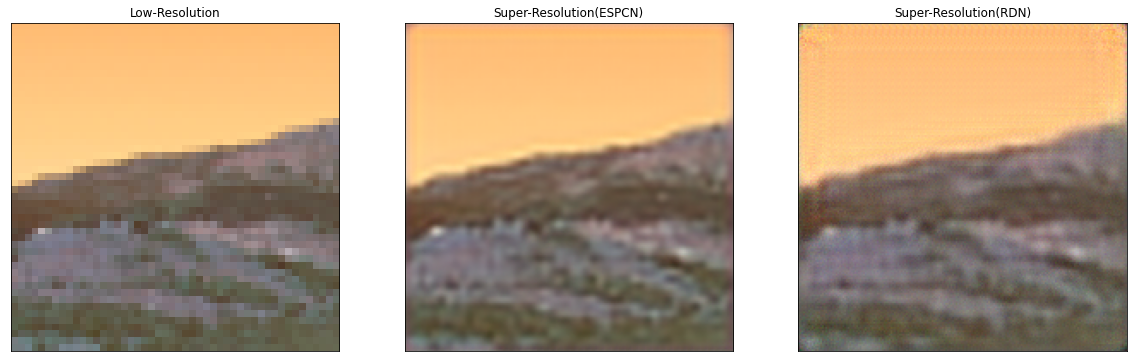

In [ ]:
sr, sr2 = plot_result('LR/0808x4_v24.png')

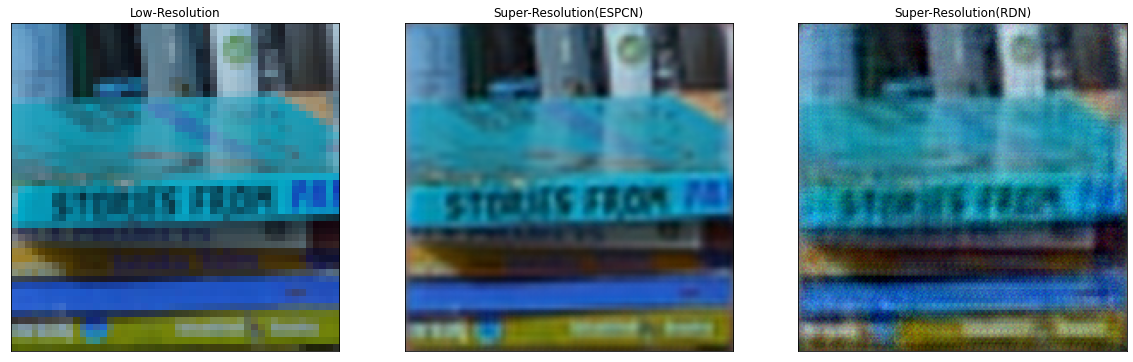

In [ ]:
sr, sr2 = plot_result('LR/0867x4_v2.png')

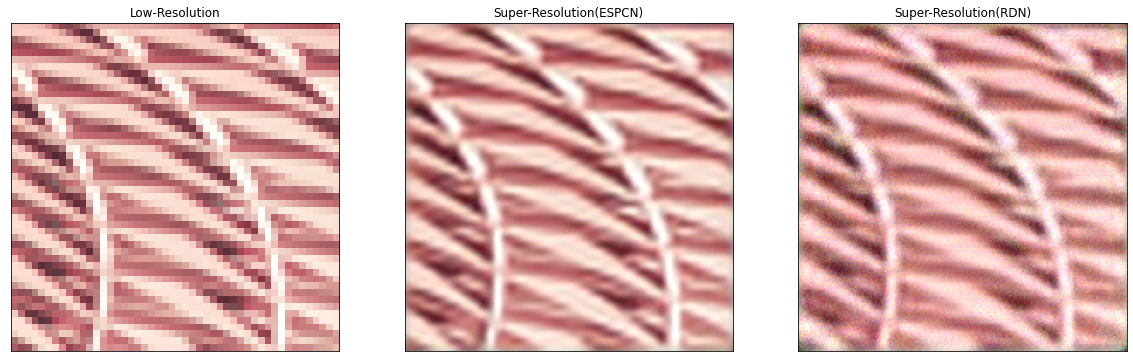

In [ ]:
sr, sr2 = plot_result('LR/0892x4_v2.png')

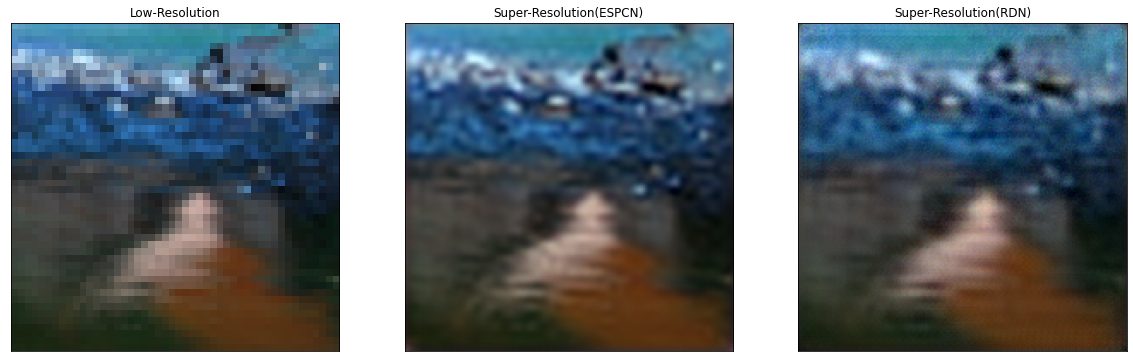

In [ ]:
sr, sr2 = plot_result('LR/0808x4_v2.png')